# Setting up inputs prior to runs with CCMALR effort
**Author**: Denisse Fierro Arcos  
**Date**: 2025-08-30  

In this notebook, inputs are prepared to run DBPM with the regional (CCAMLR) fishing effort. These runs allow us to compare the impact of the fishing effort forcing on the estimated fishing catches.

## Loading relevant libraries

In [1]:
import os
os.chdir('/g/data/vf71/la6889/dbpm_southern_ocean/scripts/')
from glob import glob
import xarray as xr
import json
import pandas as pd
import numpy as np
import useful_functions as uf
from dask.distributed import Client

## Loading regional (CCAMLR) fishing effort

In [2]:
ccamlr_effort = pd.read_parquet('../data/input_ccamlr_effort_gridded.parquet')

## Variables defining FAO sector to be processed

In [3]:
# Identifying sector and resolution of interest
reg = 'weddell'
model_res = '025deg'
reg_int = 'fao-48'

# Creating paths to input and output folders
base_folder = os.path.join('/g/data/vf71/la6889/dbpm_inputs', reg)
out_folder = os.path.join(base_folder, 'gridded_params', model_res)
os.makedirs(out_folder, exist_ok = True)

## Loading relevant data

In [4]:
#Depth to be used for land masking
depth = xr.open_zarr(glob(
    os.path.join(base_folder, 'gridded', model_res, '*obsclim_deptho_*'))[0])['deptho']

## Extract fishing effort for sector of interest

In [5]:
# Subsetting CCAMLR effort dataset
new_eff = ccamlr_effort[ccamlr_effort.region == reg_int.replace('-', ' ').upper()]

# Transforming to Data Array
ccamlr_eff = (xr.DataArray(new_eff['eff_rel_area'], dims = 'time',
                           coords = {'time': pd.to_datetime(new_eff.time.values)}).
    expand_dims({'lat': depth.lat, 'lon': depth.lon}).transpose('time', 'lat', 'lon').
    where(np.isfinite(depth)))
# Adding variable name
ccamlr_eff.name = 'effort'

In [6]:
# Identify year when fishing effort data became available for sector of interest
yr = new_eff.time.min().year

# Load fishing effort DBPM output from the month before the start of CCAMLR data
eff_ds = (xr.open_mfdataset(
    glob(os.path.join(base_folder, 'run_fishing_seaicemask', model_res, f'effort*{yr-1}*'))).
    sel(time = f'{yr-1}-12'))['effort']

eff_ds.time

<xarray.DataArray 'time' (time: 1)> Size: 8B
array(['1969-12-01T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 8B 1969-12-01

In [7]:
# Merge effort from DBPM and CCAMLR
ccamlr_eff = xr.concat([eff_ds, ccamlr_eff], dim = 'time')
# Ensure chunks are the same for both data sources
ccamlr_eff = ccamlr_eff.chunk({'time': -1, 'lat': -1, 'lon': -1})

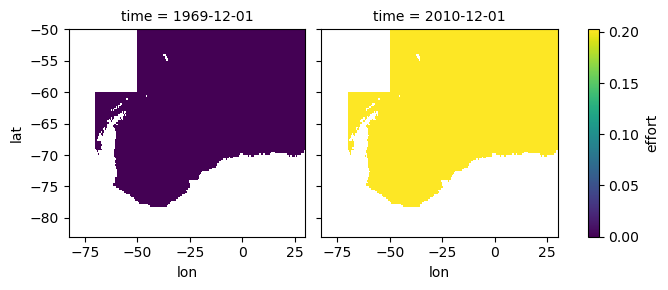

In [8]:
# Check resulting effort data prior to saving
# Note that the first timestep should look different to last due to sea ice mask
ccamlr_eff.isel(time = [0, -1]).plot(col = 'time')

## Saving CCMALR effort

In [9]:
ccamlr_eff.to_zarr(
    os.path.join(out_folder, f'new_eff_{model_res}_{reg_int}_monthly_{yr}_2010.zarr/'),
                   consolidated = True, mode = 'w')

## *Optional step:* Run only if monthly DBPM outputs for biomass are not available

In [72]:
# Load biomass for detritivores, detritus and predators for November of 
# the year prior CCAMLR data becoming available
init_ds = (xr.open_mfdataset(
    glob(os.path.join(base_folder, 'run_fishing_seaicemask', model_res, 
                      f'[p|d]*s_*{yr-1}.nc'))).sel(time = f'{yr-1}-11'))

### Save November data as a separate file

In [73]:
init_ds.detritus.to_netcdf(
    os.path.join(base_folder, 'run_fishing_seaicemask', model_res,
                 f'detritus_{model_res}_{reg_int}_{yr-1}-11.nc'))
init_ds.detritivores.to_netcdf(
    os.path.join(base_folder, 'run_fishing_seaicemask', model_res,
                 f'detritivores_{model_res}_{reg_int}_{yr-1}-11.nc'))
init_ds.predators.to_netcdf(
    os.path.join(base_folder, 'run_fishing_seaicemask', model_res,
                 f'predators_{model_res}_{reg_int}_{yr-1}-11.nc'))